# Generative Adversarial Networks: Wasserstein metric

It is a version of a GAN that is try to cure the `JAX-blob_GAN_vanilla.ipynb` when the number of blobs >= 8.
The key pis to use a different loss. The code is a simple implementation of [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with a [gradient penalty](https://arxiv.org/abs/1704.00028) (instead of the original weight clipping procedure).

First the loss is the Wasserstein-I also known as the Earth-Mover distance. 
Compared to the vanilla GAN, the Generator has the same purpose, but the vanilla Discriminator is replaced by a model, nammed "critic", $f_w$ optimised among K-Lipschitz functions such that
$$
\large{
\min_{\|f_w\|\leq K} \{ \mathbb{E}_{z\sim p(z)}[f_w(G(z)] - \mathbb{E}_{x\sim p_{data}(x)}[f_w(x)]\}
}
$$
Notice that $f_w$ does not produce a probability. In practice, the first idea to force the Lipschitz property was the $w$-weigth clipping but this leads to difficulties, so the next idea was the use loss penalty. The 2nd paper cited above add to the above loss a gradient penalty as
$$
\large{
\lambda\ \mathbb{E}_{\tilde{x}}\{(\|\nabla_x f_w(\tilde{x})\|_2 -1)^2\} \qquad \tilde{x} = \varepsilon x + (1-\varepsilon) G(z), \quad \varepsilon \sim \mathcal{U}(0,1)
}
$$
with $\| \|_2$ the 2-norm for vector, and $\lambda$ an hyperparameter. 

The generator is optimized using the loss
$$
\large{
\min_{G} \{ - f_w(G(z)\}
}
$$

This Wasserstein GAN is said to be more stable but may be long to optimize du to the gradiant penalty. 
With 8 blobs you will see that the sampling is not perfect even if all the modes are identified...

If the reader is interested, the following paper on [lightweight-gan](https://openreview.net/pdf?id=1Fqg133qRaI) may be interested by different loss used for image generation.


This notebook was inspired by [this nb](https://github.com/dhyaaalayed/wgan-gaussian) and [this one also](https://colab.research.google.com/github/lweitkamp/GANs-JAX/blob/main/2_GANs.ipynb). 




In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Run it on a TPU (if possible)!
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
except:
  pass


In [3]:
import os
from functools import partial

import jax
import jax.numpy as jnp

from typing import Any, Tuple

PRNGKey = jnp.ndarray

num_devices = jax.device_count()

In [4]:
num_devices

1

In [5]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

2025-01-30 17:39:42.547601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738255184.580801  796305 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738255185.586612  796305 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import haiku as hk

In [172]:
args = {
    'x_dim': 2,
    'z_dim': 2,
    'seed': 10,
}

args['num_blobs'] = 8 

# Set the parallel batch size.
args['batch_size'] = 32 * num_devices if num_devices > 1 else  32
args['epochs'] = 1_000
args['batch_size_p'] = args['batch_size'] //  num_devices
#
args['init_lr'] = 5e-5 # initial optim learning rate
args['lambda'] = 2 # gradient penalty lambda parameter

# Dataset

In [173]:
def make_dataset_gaussian_blobs(
    seed: int,
    batch_size: int = 1,
    num_batches: int = 1,
    num_blobs: int = args['num_blobs'],          
    r: float = 2.0,
    SCALE: float = 0.2
):
    prng_seq = hk.PRNGSequence(seed)
    offset = 0  # jnp.pi / num_blobs
    thetas = jnp.linspace(offset, 2 * jnp.pi + offset, num_blobs, endpoint=False)
    x = r * jnp.cos(thetas)
    y = r * jnp.sin(thetas)
    loc = jnp.stack([x, y], axis=-1)

    dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            probs=[1 / num_blobs for _ in range(num_blobs)]
        ),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=loc, scale_diag=SCALE * jnp.ones((num_blobs, 2))
        ),
    )

    for _ in range(num_batches):
        key = next(prng_seq)
        data = dist.sample(seed=key, sample_shape=(batch_size,))
        yield data/jnp.max(jnp.abs(data))



make_dataset = make_dataset_gaussian_blobs
xlim, ylim = [-1,1], [-1,1]


In [174]:
data_batch = make_dataset(
        seed=2025, batch_size=args['batch_size']*40, num_batches=1   # keep batch_size a multiple of args['batch_size']
    )
X_train = next(data_batch)

In [175]:
len(X_train)

1280

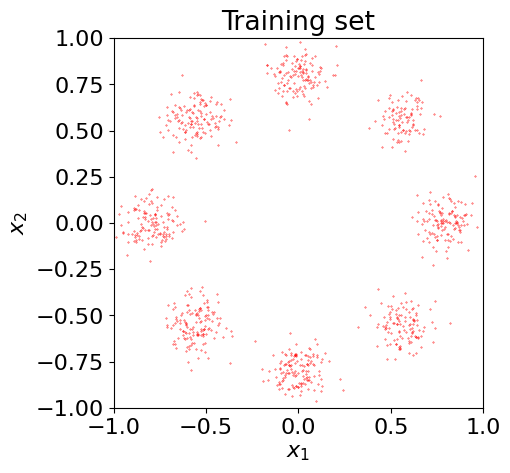

In [176]:
plt.scatter(X_train[:1000, 0], X_train[:1000, 1], s=0.1, color='red',label='Train')
plt.title("Training set")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect('equal')

In [177]:
batches_in_epoch = len(X_train) // args['batch_size']

In [178]:
batches_in_epoch

40

In [179]:
import itertools  
data_gen = itertools.cycle(jnp.array(jnp.array_split(jax.random.permutation(jax.random.PRNGKey(42),X_train), batches_in_epoch )))

# Gen & Critic simple architectures

In [180]:
import functools
from typing import Any, Callable, Sequence, Optional
import jax
from jax import lax, random, numpy as jnp
import flax
from flax import linen as nn


from jax.nn.initializers import normal as normal_init
from flax.training import train_state


In [181]:
TrainState = train_state.TrainState

class Generator(nn.Module):
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, z: jnp.ndarray, train: bool = True):

    x = z.reshape((args['batch_size_p'], args['z_dim']))
    x = nn.Dense(512,name=f'Gen_layers_1', dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Gen_layers_2', dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Gen_layers_3', dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(args['x_dim'],name=f'Gen_layers_4', dtype=self.dtype)(x)
    return x


class Critic(nn.Module):
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x: jnp.ndarray, train: bool = True):

    x = nn.Dense(512,name=f'Dis_layers_1',dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Dis_layers_2',dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(512,name=f'Dis_layers_3',dtype=self.dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(1,name=f'Dis_layers_4',dtype=self.dtype)(x)
    return x.reshape((x.shape[0], -1))

# GAN Loss

In [182]:
import optax

In [183]:
@partial(jax.pmap, axis_name='num_devices')
def generator_step(generator_state: TrainState,
                   critic_state: TrainState,
                   key: PRNGKey):
  r"""The generator is updated by generating data
  """
  input_noise = jax.random.uniform(key, (args['batch_size_p'], args['z_dim']), minval=-1,maxval=1) # normal

  def loss_fn(params):
    generated_data = generator_state.apply_fn(
        {'params': params},
        input_noise)
    
    values = critic_state.apply_fn(
            {'params': critic_state.params},                                                                                      
             generated_data)

    loss = -values.mean()

    return loss
  
  grad_fn = jax.value_and_grad(loss_fn)
  loss,  grads = grad_fn(generator_state.params)

  # Average across the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Update the Generator through gradient descent.
  new_generator_state = generator_state.apply_gradients(
      grads=grads)
  
  return new_generator_state, loss

@partial(jax.pmap, axis_name='num_devices')
def critic_step(generator_state: TrainState,
                       critic_state: TrainState,
                       real_data: jnp.ndarray,
                       key: PRNGKey):
  r"""The critic optimized with both real and generated data,
  It's loss goes down as it predicts correctly if images are real or generated.
  """
  input_noise = jax.random.uniform(key, (args['batch_size_p'], args['z_dim']), minval=-1,maxval=1) # normal

  generated_data = generator_state.apply_fn(
        {'params': generator_state.params}, 
         input_noise)
  
  def loss_fn(params, key):

    @partial(jax.vmap, in_axes=(None, 0))
    @partial(jax.grad, argnums=1)
    def critic_forward(params, input_image):
      """Helper function to calculate the gradients with respect to the input."""
      value = critic_state.apply_fn(
          {'params': params}, 
          input_image, 
          )
      return value[0,0]
    
    vals_real = critic_state.apply_fn(
        {'params': params},
        real_data)
        
    vals_generated = critic_state.apply_fn(
        {'params': params},
        generated_data)

    # Interpolate between fake and real images with epsilon
    
    epsilon = jax.random.uniform(key, shape=(args['batch_size_p'],1))
    data_mix = real_data * epsilon + generated_data * (1 - epsilon)
    # Fetch the gradient penalty
    gradients = critic_forward(params, data_mix)
    gradients = gradients.reshape((gradients.shape[0], -1))
    grad_norm = jnp.linalg.norm(gradients, axis=1)
    grad_penalty = ((grad_norm - 1) ** 2)

    loss = -vals_real.mean() + vals_generated.mean() + args["lambda"] * grad_penalty.mean()
      
    return loss 

  key, subkey = jax.random.split(key)
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(critic_state.params, subkey)

  # Average cross the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  new_critic_state = critic_state.apply_gradients(
      grads=grads)
  
  return new_critic_state, loss



# Training
restart from here if you want to change training parameters

In [184]:
import shutil
import os
dirpath = os.path.join("./","results", "test2D")
print(dirpath)
os.makedirs(dirpath,exist_ok=True)

./results/test2D


In [185]:
import glob
files = glob.glob(f'{dirpath}/GAN*')
for f in files:
    os.remove(f)

In [186]:
@partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_state(rng, model_cls, input_shape): 
  r"""Create the training state given a model class. """ 
  model = model_cls()

  tx = optax.adam(args['init_lr'],b1=0.5,b2=0.999)
  variables = model.init(rng, jnp.ones(input_shape))

  state = TrainState.create(apply_fn=model.apply, tx=tx, 
      params=variables['params'])

  return state


@jax.pmap
def sample_from_generator(generator_state, input_noise):
  """Sample from the generator in evaluation mode."""
  generated_data = generator_state.apply_fn(
      {'params': generator_state.params},
      input_noise, train=False)
  return generated_data

In [187]:
from flax.training.common_utils import shard, shard_prng_key


key = jax.random.PRNGKey(seed=args['seed'])
key_generator, key_critic, key = jax.random.split(key, 3)
key_generator = shard_prng_key(key_generator)
key_critic = shard_prng_key(key_critic)

critic_state = create_state(key_critic, Critic,
    (args['batch_size_p'], *next(data_gen).shape[1:]))

generator_state = create_state(key_generator, Generator, 
    (args['batch_size_p'], args['z_dim']))

generator_input = jax.random.uniform(key, (args['batch_size'], args['z_dim']), minval=-1,maxval=1) # normal
generator_input = shard(generator_input)

In [188]:
key, key_generator, key_critic = jax.random.split(key, 3)
key_generator = shard_prng_key(key_generator)
key_critic = shard_prng_key(key_critic)

# Shard the data to possible devices.
batch_data = shard(next(data_gen))

# Take a step with the generator.
generator_state, generator_loss = generator_step(generator_state, 
          critic_state, key_generator)

In [189]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

info_gen_losses=[]
info_cri_losses=[]

for epoch in tqdm(range(1, args['epochs'] + 1), desc="Epoch...",
                  position=0, leave=True):
  
  with tqdm(total=batches_in_epoch, desc="Training...",
            leave=False) as progress_bar_train:
    for batch in range(batches_in_epoch):

      # Generate RNG keys for generator and critic.
      key, key_generator, key_critic = jax.random.split(key, 3)
      key_generator = shard_prng_key(key_generator)

      # Shard the data to possible devices.
      batch_data = shard(next(data_gen))

      # Take a step with the generator.
      generator_state, generator_loss = generator_step(generator_state, 
          critic_state, key_generator)

      # Take a step with the critic.
      for _ in range(5): 
          key, key_critic = jax.random.split(key, 2)
          key_critic = shard_prng_key(key_critic)
          critic_state, critic_loss = critic_step(
              generator_state, critic_state, batch_data, key_critic)
    

      progress_bar_train.update(1)
    
    metrics = jax.device_get([generator_loss[0], critic_loss[1]])

    info_gen_losses.append(metrics[0])
    info_cri_losses.append(metrics[1])
      
    message = f"Epoch: {epoch: <2} | "
    message += f"Generator loss: {metrics[0]:.3f} | "
    message += f"Critic loss: {metrics[1]:.3f}"
    progress_bar_train.write(message)

  # Sample from the generator using the fixed input. We need to
  # reshape if we are working on multiple devices.
  sample = sample_from_generator(generator_state, generator_input)
  sample = sample.reshape((-1,args['x_dim']))

  # Next, plot the static samples, save the fig to disk.
  if epoch % (args['epochs']//10) == 0:
    np.save(f"./results/test2D/GAN_epoch_{epoch}.npy",sample)

Epoch...:   0%|          | 0/1000 [00:00<?, ?it/s]

Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1  | Generator loss: -0.684 | Critic loss: -0.135


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2  | Generator loss: 0.662 | Critic loss: -0.152


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3  | Generator loss: 0.452 | Critic loss: -0.402


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4  | Generator loss: 0.662 | Critic loss: 0.184


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5  | Generator loss: 0.648 | Critic loss: -0.520


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6  | Generator loss: -0.345 | Critic loss: -0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7  | Generator loss: 0.476 | Critic loss: 0.356


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8  | Generator loss: -0.778 | Critic loss: -0.083


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9  | Generator loss: 0.364 | Critic loss: 0.456


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Generator loss: -0.142 | Critic loss: -0.419


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Generator loss: 0.243 | Critic loss: -0.239


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Generator loss: -0.352 | Critic loss: 0.496


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Generator loss: -0.335 | Critic loss: 0.159


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Generator loss: 0.235 | Critic loss: 0.468


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Generator loss: -0.084 | Critic loss: -0.134


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Generator loss: -0.499 | Critic loss: 0.201


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Generator loss: 0.221 | Critic loss: 0.601


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Generator loss: -0.760 | Critic loss: -0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Generator loss: 0.618 | Critic loss: 0.135


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Generator loss: -0.133 | Critic loss: -0.587


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21 | Generator loss: -0.763 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22 | Generator loss: 0.251 | Critic loss: 0.520


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23 | Generator loss: -0.089 | Critic loss: -0.140


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24 | Generator loss: -0.156 | Critic loss: -0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25 | Generator loss: 0.512 | Critic loss: 0.260


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 26 | Generator loss: 0.588 | Critic loss: -0.157


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 27 | Generator loss: -0.028 | Critic loss: 0.410


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28 | Generator loss: -0.311 | Critic loss: -0.544


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29 | Generator loss: 0.828 | Critic loss: -0.255


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30 | Generator loss: -0.334 | Critic loss: -0.249


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 31 | Generator loss: 0.459 | Critic loss: 0.052


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 32 | Generator loss: -0.264 | Critic loss: -0.556


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 33 | Generator loss: -0.631 | Critic loss: -0.213


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 34 | Generator loss: 0.535 | Critic loss: 0.097


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 35 | Generator loss: 0.190 | Critic loss: -0.053


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 36 | Generator loss: -0.867 | Critic loss: 0.218


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 37 | Generator loss: -0.627 | Critic loss: 0.145


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 38 | Generator loss: 0.567 | Critic loss: 0.356


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 39 | Generator loss: -0.396 | Critic loss: -0.343


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 40 | Generator loss: 0.311 | Critic loss: -0.068


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 41 | Generator loss: -0.174 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 42 | Generator loss: 0.317 | Critic loss: 0.645


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 43 | Generator loss: -0.423 | Critic loss: -0.444


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 44 | Generator loss: 1.003 | Critic loss: -0.127


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 45 | Generator loss: -0.303 | Critic loss: -0.201


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 46 | Generator loss: -0.730 | Critic loss: -0.144


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 47 | Generator loss: 0.478 | Critic loss: 0.451


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 48 | Generator loss: -0.660 | Critic loss: -0.199


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 49 | Generator loss: 0.749 | Critic loss: -0.531


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 50 | Generator loss: -0.703 | Critic loss: -0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 51 | Generator loss: 0.359 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 52 | Generator loss: 0.751 | Critic loss: -0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 53 | Generator loss: 0.202 | Critic loss: 0.653


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 54 | Generator loss: 0.145 | Critic loss: -0.472


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 55 | Generator loss: -0.111 | Critic loss: -0.116


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 56 | Generator loss: 0.109 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 57 | Generator loss: -0.000 | Critic loss: -0.283


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 58 | Generator loss: 0.004 | Critic loss: -0.255


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 59 | Generator loss: -1.104 | Critic loss: 0.183


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 60 | Generator loss: 0.510 | Critic loss: 0.416


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 61 | Generator loss: -0.181 | Critic loss: -0.605


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 62 | Generator loss: -0.699 | Critic loss: -0.049


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 63 | Generator loss: 0.488 | Critic loss: 0.393


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 64 | Generator loss: -0.488 | Critic loss: -0.234


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 65 | Generator loss: 0.363 | Critic loss: 0.242


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 66 | Generator loss: 0.565 | Critic loss: 0.207


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 67 | Generator loss: -0.453 | Critic loss: -0.435


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 68 | Generator loss: 0.698 | Critic loss: 0.268


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 69 | Generator loss: 0.789 | Critic loss: -0.100


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 70 | Generator loss: 0.362 | Critic loss: 0.148


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 71 | Generator loss: 0.092 | Critic loss: -0.138


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 72 | Generator loss: 0.088 | Critic loss: -0.249


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 73 | Generator loss: -0.067 | Critic loss: -0.259


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 74 | Generator loss: -0.381 | Critic loss: -0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 75 | Generator loss: -0.889 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 76 | Generator loss: 0.202 | Critic loss: -0.285


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 77 | Generator loss: -0.680 | Critic loss: 0.226


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 78 | Generator loss: 0.492 | Critic loss: 0.320


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 79 | Generator loss: -0.319 | Critic loss: -0.109


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 80 | Generator loss: 0.206 | Critic loss: 0.151


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 81 | Generator loss: 0.495 | Critic loss: 0.330


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 82 | Generator loss: -0.540 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 83 | Generator loss: 0.437 | Critic loss: 0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 84 | Generator loss: -0.536 | Critic loss: -0.238


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 85 | Generator loss: 0.652 | Critic loss: 0.102


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 86 | Generator loss: -0.498 | Critic loss: 0.098


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 87 | Generator loss: -0.538 | Critic loss: 0.131


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 88 | Generator loss: 0.095 | Critic loss: -0.312


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 89 | Generator loss: 0.560 | Critic loss: -0.070


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 90 | Generator loss: 0.355 | Critic loss: 0.522


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 91 | Generator loss: -0.086 | Critic loss: -0.598


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 92 | Generator loss: -0.580 | Critic loss: -0.147


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 93 | Generator loss: -0.638 | Critic loss: -0.165


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 94 | Generator loss: 0.217 | Critic loss: -0.213


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 95 | Generator loss: 0.389 | Critic loss: -0.390


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 96 | Generator loss: -0.248 | Critic loss: -0.215


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 97 | Generator loss: 0.814 | Critic loss: 0.085


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 98 | Generator loss: -0.011 | Critic loss: -0.221


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 99 | Generator loss: -0.407 | Critic loss: -0.331


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100 | Generator loss: -0.249 | Critic loss: -0.048


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 101 | Generator loss: 1.147 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 102 | Generator loss: -0.400 | Critic loss: 0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 103 | Generator loss: 0.774 | Critic loss: 0.205


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 104 | Generator loss: -0.364 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 105 | Generator loss: 0.633 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 106 | Generator loss: 0.027 | Critic loss: 0.059


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 107 | Generator loss: 0.574 | Critic loss: 0.305


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 108 | Generator loss: -0.296 | Critic loss: -0.291


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 109 | Generator loss: 0.180 | Critic loss: -0.144


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 110 | Generator loss: -0.471 | Critic loss: -0.125


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 111 | Generator loss: 0.547 | Critic loss: 0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 112 | Generator loss: -0.714 | Critic loss: 0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 113 | Generator loss: 0.808 | Critic loss: 0.357


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 114 | Generator loss: -0.272 | Critic loss: -0.420


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 115 | Generator loss: 0.285 | Critic loss: -0.121


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 116 | Generator loss: -0.390 | Critic loss: -0.131


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 117 | Generator loss: -0.245 | Critic loss: -0.107


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 118 | Generator loss: -0.099 | Critic loss: -0.188


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 119 | Generator loss: -0.054 | Critic loss: -0.146


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 120 | Generator loss: -0.156 | Critic loss: -0.156


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 121 | Generator loss: -0.207 | Critic loss: -0.106


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 122 | Generator loss: -0.068 | Critic loss: -0.147


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 123 | Generator loss: -0.082 | Critic loss: -0.141


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 124 | Generator loss: -0.158 | Critic loss: -0.124


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 125 | Generator loss: -0.069 | Critic loss: -0.101


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 126 | Generator loss: -0.121 | Critic loss: -0.155


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 127 | Generator loss: -0.097 | Critic loss: -0.216


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 128 | Generator loss: -0.088 | Critic loss: -0.113


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 129 | Generator loss: -0.072 | Critic loss: -0.087


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 130 | Generator loss: -0.040 | Critic loss: -0.199


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 131 | Generator loss: -0.064 | Critic loss: -0.150


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 132 | Generator loss: -0.067 | Critic loss: -0.074


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 133 | Generator loss: -0.026 | Critic loss: -0.087


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 134 | Generator loss: -0.006 | Critic loss: -0.086


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 135 | Generator loss: -0.003 | Critic loss: -0.129


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 136 | Generator loss: 0.015 | Critic loss: -0.154


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 137 | Generator loss: 0.037 | Critic loss: -0.119


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 138 | Generator loss: 0.034 | Critic loss: -0.065


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 139 | Generator loss: 0.082 | Critic loss: -0.153


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 140 | Generator loss: 0.006 | Critic loss: -0.133


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 141 | Generator loss: 0.035 | Critic loss: -0.144


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 142 | Generator loss: 0.101 | Critic loss: -0.083


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 143 | Generator loss: 0.019 | Critic loss: -0.150


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 144 | Generator loss: 0.036 | Critic loss: -0.092


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 145 | Generator loss: 0.009 | Critic loss: -0.147


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 146 | Generator loss: 0.055 | Critic loss: -0.145


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 147 | Generator loss: 0.053 | Critic loss: -0.120


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 148 | Generator loss: 0.022 | Critic loss: -0.142


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 149 | Generator loss: 0.088 | Critic loss: -0.097


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 150 | Generator loss: 0.094 | Critic loss: -0.183


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 151 | Generator loss: 0.090 | Critic loss: -0.083


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 152 | Generator loss: 0.098 | Critic loss: -0.134


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 153 | Generator loss: 0.070 | Critic loss: -0.083


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 154 | Generator loss: 0.055 | Critic loss: -0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 155 | Generator loss: 0.041 | Critic loss: -0.072


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 156 | Generator loss: 0.151 | Critic loss: -0.093


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 157 | Generator loss: 0.133 | Critic loss: -0.051


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 158 | Generator loss: 0.143 | Critic loss: -0.090


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 159 | Generator loss: 0.028 | Critic loss: -0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 160 | Generator loss: 0.047 | Critic loss: 0.035


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 161 | Generator loss: 0.163 | Critic loss: -0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 162 | Generator loss: 0.069 | Critic loss: -0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 163 | Generator loss: 0.061 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 164 | Generator loss: 0.102 | Critic loss: -0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 165 | Generator loss: 0.005 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 166 | Generator loss: 0.001 | Critic loss: -0.088


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 167 | Generator loss: 0.128 | Critic loss: 0.106


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 168 | Generator loss: 0.122 | Critic loss: -0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 169 | Generator loss: 0.087 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 170 | Generator loss: 0.087 | Critic loss: 0.069


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 171 | Generator loss: 0.211 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 172 | Generator loss: 0.224 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 173 | Generator loss: 0.185 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 174 | Generator loss: 0.194 | Critic loss: 0.048


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 175 | Generator loss: 0.375 | Critic loss: 0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 176 | Generator loss: 0.176 | Critic loss: -0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 177 | Generator loss: 0.266 | Critic loss: 0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 178 | Generator loss: 0.457 | Critic loss: 0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 179 | Generator loss: 0.246 | Critic loss: 0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 180 | Generator loss: 0.337 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 181 | Generator loss: 0.250 | Critic loss: 0.100


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 182 | Generator loss: 0.352 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 183 | Generator loss: 0.293 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 184 | Generator loss: 0.264 | Critic loss: 0.066


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 185 | Generator loss: 0.323 | Critic loss: 0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 186 | Generator loss: 0.395 | Critic loss: 0.068


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 187 | Generator loss: 0.369 | Critic loss: 0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 188 | Generator loss: 0.309 | Critic loss: 0.083


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 189 | Generator loss: 0.392 | Critic loss: 0.096


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 190 | Generator loss: 0.762 | Critic loss: 0.087


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 191 | Generator loss: 0.687 | Critic loss: 0.149


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 192 | Generator loss: 0.512 | Critic loss: 0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 193 | Generator loss: 0.451 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 194 | Generator loss: 0.532 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 195 | Generator loss: 0.444 | Critic loss: 0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 196 | Generator loss: 0.418 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 197 | Generator loss: 0.406 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 198 | Generator loss: 0.344 | Critic loss: 0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 199 | Generator loss: 0.423 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 200 | Generator loss: 0.341 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 201 | Generator loss: 0.241 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 202 | Generator loss: 0.163 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 203 | Generator loss: 0.196 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 204 | Generator loss: 0.184 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 205 | Generator loss: 0.204 | Critic loss: 0.052


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 206 | Generator loss: 0.221 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 207 | Generator loss: 0.211 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 208 | Generator loss: 0.307 | Critic loss: -0.062


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 209 | Generator loss: 0.189 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 210 | Generator loss: 0.255 | Critic loss: 0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 211 | Generator loss: 0.101 | Critic loss: 0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 212 | Generator loss: 0.250 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 213 | Generator loss: 0.120 | Critic loss: -0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 214 | Generator loss: 0.160 | Critic loss: -0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 215 | Generator loss: 0.007 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 216 | Generator loss: 0.032 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 217 | Generator loss: 0.116 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 218 | Generator loss: 0.119 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 219 | Generator loss: 0.068 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 220 | Generator loss: 0.080 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 221 | Generator loss: 0.018 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 222 | Generator loss: 0.128 | Critic loss: -0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 223 | Generator loss: 0.120 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 224 | Generator loss: 0.062 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 225 | Generator loss: 0.070 | Critic loss: -0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 226 | Generator loss: 0.161 | Critic loss: -0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 227 | Generator loss: 0.119 | Critic loss: -0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 228 | Generator loss: 0.098 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 229 | Generator loss: 0.156 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 230 | Generator loss: 0.098 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 231 | Generator loss: 0.103 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 232 | Generator loss: 0.128 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 233 | Generator loss: 0.050 | Critic loss: -0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 234 | Generator loss: 0.063 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 235 | Generator loss: 0.123 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 236 | Generator loss: 0.077 | Critic loss: 0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 237 | Generator loss: 0.233 | Critic loss: -0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 238 | Generator loss: 0.114 | Critic loss: -0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 239 | Generator loss: 0.101 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 240 | Generator loss: 0.075 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 241 | Generator loss: 0.153 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 242 | Generator loss: 0.219 | Critic loss: -0.055


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 243 | Generator loss: 0.042 | Critic loss: -0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 244 | Generator loss: 0.036 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 245 | Generator loss: 0.056 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 246 | Generator loss: 0.045 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 247 | Generator loss: 0.098 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 248 | Generator loss: 0.022 | Critic loss: -0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 249 | Generator loss: 0.076 | Critic loss: -0.035


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 250 | Generator loss: 0.071 | Critic loss: 0.052


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 251 | Generator loss: -0.001 | Critic loss: 0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 252 | Generator loss: 0.090 | Critic loss: -0.058


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 253 | Generator loss: 0.038 | Critic loss: 0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 254 | Generator loss: 0.049 | Critic loss: 0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 255 | Generator loss: 0.115 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 256 | Generator loss: 0.109 | Critic loss: 0.052


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 257 | Generator loss: 0.062 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 258 | Generator loss: 0.024 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 259 | Generator loss: 0.093 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 260 | Generator loss: 0.069 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 261 | Generator loss: 0.082 | Critic loss: -0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 262 | Generator loss: 0.115 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 263 | Generator loss: 0.052 | Critic loss: -0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 264 | Generator loss: 0.049 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 265 | Generator loss: 0.016 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 266 | Generator loss: 0.054 | Critic loss: -0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 267 | Generator loss: 0.162 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 268 | Generator loss: 0.042 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 269 | Generator loss: 0.149 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 270 | Generator loss: 0.038 | Critic loss: -0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 271 | Generator loss: 0.143 | Critic loss: -0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 272 | Generator loss: -0.019 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 273 | Generator loss: 0.058 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 274 | Generator loss: 0.037 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 275 | Generator loss: 0.084 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 276 | Generator loss: 0.062 | Critic loss: 0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 277 | Generator loss: -0.003 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 278 | Generator loss: 0.055 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 279 | Generator loss: -0.005 | Critic loss: -0.062


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 280 | Generator loss: 0.036 | Critic loss: -0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 281 | Generator loss: 0.060 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 282 | Generator loss: -0.001 | Critic loss: 0.055


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 283 | Generator loss: -0.006 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 284 | Generator loss: 0.073 | Critic loss: 0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 285 | Generator loss: -0.014 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 286 | Generator loss: 0.048 | Critic loss: 0.035


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 287 | Generator loss: 0.053 | Critic loss: 0.061


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 288 | Generator loss: -0.005 | Critic loss: -0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 289 | Generator loss: 0.061 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 290 | Generator loss: 0.094 | Critic loss: -0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 291 | Generator loss: 0.035 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 292 | Generator loss: 0.124 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 293 | Generator loss: 0.010 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 294 | Generator loss: 0.055 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 295 | Generator loss: 0.178 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 296 | Generator loss: 0.080 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 297 | Generator loss: 0.117 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 298 | Generator loss: 0.087 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 299 | Generator loss: 0.112 | Critic loss: -0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 300 | Generator loss: 0.164 | Critic loss: 0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 301 | Generator loss: 0.179 | Critic loss: 0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 302 | Generator loss: 0.109 | Critic loss: -0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 303 | Generator loss: 0.157 | Critic loss: -0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 304 | Generator loss: 0.084 | Critic loss: 0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 305 | Generator loss: 0.132 | Critic loss: 0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 306 | Generator loss: 0.185 | Critic loss: -0.074


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 307 | Generator loss: 0.075 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 308 | Generator loss: 0.086 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 309 | Generator loss: 0.088 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 310 | Generator loss: 0.125 | Critic loss: 0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 311 | Generator loss: 0.035 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 312 | Generator loss: 0.087 | Critic loss: -0.048


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 313 | Generator loss: 0.064 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 314 | Generator loss: 0.151 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 315 | Generator loss: 0.018 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 316 | Generator loss: 0.001 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 317 | Generator loss: 0.090 | Critic loss: -0.059


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 318 | Generator loss: 0.025 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 319 | Generator loss: 0.095 | Critic loss: 0.053


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 320 | Generator loss: 0.065 | Critic loss: -0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 321 | Generator loss: 0.071 | Critic loss: -0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 322 | Generator loss: 0.040 | Critic loss: -0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 323 | Generator loss: 0.109 | Critic loss: 0.055


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 324 | Generator loss: 0.068 | Critic loss: -0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 325 | Generator loss: 0.133 | Critic loss: -0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 326 | Generator loss: 0.212 | Critic loss: -0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 327 | Generator loss: 0.109 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 328 | Generator loss: 0.063 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 329 | Generator loss: 0.137 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 330 | Generator loss: 0.141 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 331 | Generator loss: 0.071 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 332 | Generator loss: 0.152 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 333 | Generator loss: 0.062 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 334 | Generator loss: 0.077 | Critic loss: -0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 335 | Generator loss: 0.128 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 336 | Generator loss: 0.106 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 337 | Generator loss: 0.143 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 338 | Generator loss: 0.096 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 339 | Generator loss: 0.049 | Critic loss: -0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 340 | Generator loss: 0.103 | Critic loss: -0.079


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 341 | Generator loss: 0.128 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 342 | Generator loss: 0.118 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 343 | Generator loss: 0.077 | Critic loss: 0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 344 | Generator loss: 0.103 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 345 | Generator loss: 0.058 | Critic loss: -0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 346 | Generator loss: 0.120 | Critic loss: -0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 347 | Generator loss: 0.102 | Critic loss: 0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 348 | Generator loss: 0.098 | Critic loss: 0.070


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 349 | Generator loss: 0.067 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 350 | Generator loss: 0.107 | Critic loss: -0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 351 | Generator loss: 0.149 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 352 | Generator loss: 0.115 | Critic loss: 0.072


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 353 | Generator loss: 0.097 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 354 | Generator loss: 0.129 | Critic loss: 0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 355 | Generator loss: 0.092 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 356 | Generator loss: 0.075 | Critic loss: 0.048


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 357 | Generator loss: 0.058 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 358 | Generator loss: 0.079 | Critic loss: 0.049


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 359 | Generator loss: 0.118 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 360 | Generator loss: 0.073 | Critic loss: 0.060


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 361 | Generator loss: 0.137 | Critic loss: 0.066


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 362 | Generator loss: 0.047 | Critic loss: 0.048


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 363 | Generator loss: 0.085 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 364 | Generator loss: 0.018 | Critic loss: 0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 365 | Generator loss: 0.030 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 366 | Generator loss: 0.105 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 367 | Generator loss: 0.076 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 368 | Generator loss: -0.040 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 369 | Generator loss: -0.031 | Critic loss: 0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 370 | Generator loss: -0.017 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 371 | Generator loss: 0.035 | Critic loss: -0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 372 | Generator loss: 0.077 | Critic loss: 0.052


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 373 | Generator loss: 0.066 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 374 | Generator loss: 0.032 | Critic loss: 0.074


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 375 | Generator loss: 0.095 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 376 | Generator loss: 0.042 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 377 | Generator loss: 0.073 | Critic loss: 0.051


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 378 | Generator loss: 0.099 | Critic loss: 0.059


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 379 | Generator loss: 0.071 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 380 | Generator loss: 0.050 | Critic loss: 0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 381 | Generator loss: 0.074 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 382 | Generator loss: 0.014 | Critic loss: 0.058


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 383 | Generator loss: 0.027 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 384 | Generator loss: 0.054 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 385 | Generator loss: 0.091 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 386 | Generator loss: 0.056 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 387 | Generator loss: 0.072 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 388 | Generator loss: 0.094 | Critic loss: -0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 389 | Generator loss: 0.027 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 390 | Generator loss: 0.031 | Critic loss: 0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 391 | Generator loss: 0.077 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 392 | Generator loss: 0.133 | Critic loss: -0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 393 | Generator loss: 0.144 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 394 | Generator loss: 0.155 | Critic loss: -0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 395 | Generator loss: 0.142 | Critic loss: 0.059


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 396 | Generator loss: 0.096 | Critic loss: 0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 397 | Generator loss: 0.158 | Critic loss: -0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 398 | Generator loss: 0.099 | Critic loss: -0.035


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 399 | Generator loss: 0.154 | Critic loss: -0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 400 | Generator loss: 0.160 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 401 | Generator loss: 0.102 | Critic loss: -0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 402 | Generator loss: 0.133 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 403 | Generator loss: 0.097 | Critic loss: -0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 404 | Generator loss: 0.033 | Critic loss: 0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 405 | Generator loss: 0.167 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 406 | Generator loss: 0.078 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 407 | Generator loss: 0.117 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 408 | Generator loss: 0.089 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 409 | Generator loss: 0.108 | Critic loss: -0.067


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 410 | Generator loss: 0.120 | Critic loss: -0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 411 | Generator loss: 0.123 | Critic loss: -0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 412 | Generator loss: 0.025 | Critic loss: 0.068


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 413 | Generator loss: 0.128 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 414 | Generator loss: 0.170 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 415 | Generator loss: 0.185 | Critic loss: -0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 416 | Generator loss: 0.149 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 417 | Generator loss: 0.170 | Critic loss: -0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 418 | Generator loss: 0.065 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 419 | Generator loss: 0.073 | Critic loss: 0.062


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 420 | Generator loss: 0.126 | Critic loss: 0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 421 | Generator loss: 0.137 | Critic loss: 0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 422 | Generator loss: 0.163 | Critic loss: -0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 423 | Generator loss: 0.111 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 424 | Generator loss: 0.169 | Critic loss: 0.049


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 425 | Generator loss: 0.150 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 426 | Generator loss: 0.130 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 427 | Generator loss: 0.130 | Critic loss: -0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 428 | Generator loss: 0.082 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 429 | Generator loss: 0.140 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 430 | Generator loss: 0.182 | Critic loss: -0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 431 | Generator loss: 0.117 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 432 | Generator loss: 0.132 | Critic loss: 0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 433 | Generator loss: 0.114 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 434 | Generator loss: 0.051 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 435 | Generator loss: 0.129 | Critic loss: -0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 436 | Generator loss: 0.139 | Critic loss: -0.000


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 437 | Generator loss: 0.138 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 438 | Generator loss: 0.127 | Critic loss: 0.057


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 439 | Generator loss: 0.116 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 440 | Generator loss: 0.109 | Critic loss: -0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 441 | Generator loss: 0.071 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 442 | Generator loss: 0.144 | Critic loss: 0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 443 | Generator loss: 0.054 | Critic loss: -0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 444 | Generator loss: 0.176 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 445 | Generator loss: 0.176 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 446 | Generator loss: 0.199 | Critic loss: -0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 447 | Generator loss: 0.058 | Critic loss: 0.093


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 448 | Generator loss: 0.115 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 449 | Generator loss: 0.091 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 450 | Generator loss: 0.082 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 451 | Generator loss: 0.114 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 452 | Generator loss: 0.107 | Critic loss: -0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 453 | Generator loss: 0.078 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 454 | Generator loss: 0.136 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 455 | Generator loss: 0.142 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 456 | Generator loss: 0.091 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 457 | Generator loss: 0.121 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 458 | Generator loss: 0.143 | Critic loss: -0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 459 | Generator loss: 0.165 | Critic loss: -0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 460 | Generator loss: 0.093 | Critic loss: 0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 461 | Generator loss: 0.135 | Critic loss: -0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 462 | Generator loss: 0.048 | Critic loss: 0.069


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 463 | Generator loss: 0.092 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 464 | Generator loss: 0.131 | Critic loss: -0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 465 | Generator loss: 0.073 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 466 | Generator loss: 0.079 | Critic loss: 0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 467 | Generator loss: 0.123 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 468 | Generator loss: 0.104 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 469 | Generator loss: 0.031 | Critic loss: -0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 470 | Generator loss: 0.123 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 471 | Generator loss: 0.026 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 472 | Generator loss: 0.156 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 473 | Generator loss: 0.100 | Critic loss: 0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 474 | Generator loss: 0.076 | Critic loss: 0.061


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 475 | Generator loss: 0.099 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 476 | Generator loss: 0.032 | Critic loss: 0.053


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 477 | Generator loss: 0.112 | Critic loss: -0.065


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 478 | Generator loss: 0.140 | Critic loss: 0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 479 | Generator loss: 0.074 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 480 | Generator loss: 0.126 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 481 | Generator loss: 0.073 | Critic loss: 0.058


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 482 | Generator loss: 0.118 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 483 | Generator loss: 0.015 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 484 | Generator loss: 0.087 | Critic loss: -0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 485 | Generator loss: 0.153 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 486 | Generator loss: 0.069 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 487 | Generator loss: 0.122 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 488 | Generator loss: 0.155 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 489 | Generator loss: 0.068 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 490 | Generator loss: 0.137 | Critic loss: -0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 491 | Generator loss: 0.124 | Critic loss: 0.058


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 492 | Generator loss: 0.046 | Critic loss: 0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 493 | Generator loss: 0.022 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 494 | Generator loss: 0.130 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 495 | Generator loss: 0.117 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 496 | Generator loss: 0.087 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 497 | Generator loss: 0.029 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 498 | Generator loss: 0.148 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 499 | Generator loss: 0.134 | Critic loss: 0.052


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 500 | Generator loss: 0.085 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 501 | Generator loss: 0.072 | Critic loss: 0.063


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 502 | Generator loss: 0.148 | Critic loss: -0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 503 | Generator loss: 0.006 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 504 | Generator loss: 0.083 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 505 | Generator loss: 0.111 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 506 | Generator loss: 0.121 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 507 | Generator loss: 0.051 | Critic loss: 0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 508 | Generator loss: 0.092 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 509 | Generator loss: 0.150 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 510 | Generator loss: 0.016 | Critic loss: 0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 511 | Generator loss: 0.132 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 512 | Generator loss: 0.084 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 513 | Generator loss: 0.170 | Critic loss: -0.000


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 514 | Generator loss: 0.153 | Critic loss: -0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 515 | Generator loss: 0.194 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 516 | Generator loss: 0.054 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 517 | Generator loss: 0.167 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 518 | Generator loss: 0.115 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 519 | Generator loss: 0.085 | Critic loss: 0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 520 | Generator loss: 0.175 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 521 | Generator loss: 0.146 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 522 | Generator loss: 0.085 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 523 | Generator loss: 0.125 | Critic loss: 0.000


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 524 | Generator loss: 0.142 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 525 | Generator loss: 0.060 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 526 | Generator loss: 0.119 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 527 | Generator loss: 0.075 | Critic loss: 0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 528 | Generator loss: 0.012 | Critic loss: 0.060


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 529 | Generator loss: 0.093 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 530 | Generator loss: 0.091 | Critic loss: 0.069


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 531 | Generator loss: 0.085 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 532 | Generator loss: 0.090 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 533 | Generator loss: -0.006 | Critic loss: 0.075


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 534 | Generator loss: 0.034 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 535 | Generator loss: 0.071 | Critic loss: 0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 536 | Generator loss: 0.075 | Critic loss: 0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 537 | Generator loss: 0.040 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 538 | Generator loss: 0.003 | Critic loss: 0.000


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 539 | Generator loss: 0.075 | Critic loss: 0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 540 | Generator loss: 0.022 | Critic loss: 0.075


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 541 | Generator loss: 0.112 | Critic loss: -0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 542 | Generator loss: 0.020 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 543 | Generator loss: 0.091 | Critic loss: -0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 544 | Generator loss: 0.096 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 545 | Generator loss: -0.016 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 546 | Generator loss: 0.023 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 547 | Generator loss: 0.033 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 548 | Generator loss: -0.092 | Critic loss: 0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 549 | Generator loss: 0.003 | Critic loss: 0.058


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 550 | Generator loss: -0.081 | Critic loss: 0.062


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 551 | Generator loss: -0.067 | Critic loss: 0.075


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 552 | Generator loss: -0.194 | Critic loss: 0.053


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 553 | Generator loss: -0.076 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 554 | Generator loss: 0.047 | Critic loss: -0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 555 | Generator loss: -0.035 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 556 | Generator loss: -0.045 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 557 | Generator loss: 0.059 | Critic loss: 0.066


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 558 | Generator loss: 0.017 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 559 | Generator loss: 0.014 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 560 | Generator loss: 0.043 | Critic loss: 0.079


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 561 | Generator loss: -0.082 | Critic loss: 0.096


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 562 | Generator loss: 0.008 | Critic loss: 0.085


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 563 | Generator loss: -0.058 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 564 | Generator loss: -0.013 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 565 | Generator loss: -0.029 | Critic loss: 0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 566 | Generator loss: 0.018 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 567 | Generator loss: -0.089 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 568 | Generator loss: -0.019 | Critic loss: 0.089


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 569 | Generator loss: -0.090 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 570 | Generator loss: -0.049 | Critic loss: 0.035


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 571 | Generator loss: -0.091 | Critic loss: 0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 572 | Generator loss: -0.116 | Critic loss: 0.062


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 573 | Generator loss: -0.172 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 574 | Generator loss: -0.097 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 575 | Generator loss: -0.085 | Critic loss: -0.000


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 576 | Generator loss: -0.179 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 577 | Generator loss: -0.049 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 578 | Generator loss: -0.147 | Critic loss: -0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 579 | Generator loss: -0.142 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 580 | Generator loss: -0.140 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 581 | Generator loss: -0.290 | Critic loss: 0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 582 | Generator loss: -0.143 | Critic loss: 0.057


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 583 | Generator loss: -0.139 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 584 | Generator loss: -0.224 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 585 | Generator loss: -0.059 | Critic loss: -0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 586 | Generator loss: -0.153 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 587 | Generator loss: -0.217 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 588 | Generator loss: -0.105 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 589 | Generator loss: -0.205 | Critic loss: -0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 590 | Generator loss: -0.249 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 591 | Generator loss: -0.126 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 592 | Generator loss: -0.158 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 593 | Generator loss: -0.255 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 594 | Generator loss: -0.250 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 595 | Generator loss: -0.240 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 596 | Generator loss: -0.264 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 597 | Generator loss: -0.237 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 598 | Generator loss: -0.304 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 599 | Generator loss: -0.202 | Critic loss: 0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 600 | Generator loss: -0.331 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 601 | Generator loss: -0.210 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 602 | Generator loss: -0.219 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 603 | Generator loss: -0.304 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 604 | Generator loss: -0.224 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 605 | Generator loss: -0.222 | Critic loss: -0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 606 | Generator loss: -0.251 | Critic loss: -0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 607 | Generator loss: -0.258 | Critic loss: 0.060


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 608 | Generator loss: -0.325 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 609 | Generator loss: -0.303 | Critic loss: 0.059


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 610 | Generator loss: -0.195 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 611 | Generator loss: -0.213 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 612 | Generator loss: -0.287 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 613 | Generator loss: -0.284 | Critic loss: 0.059


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 614 | Generator loss: -0.127 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 615 | Generator loss: -0.263 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 616 | Generator loss: -0.346 | Critic loss: -0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 617 | Generator loss: -0.265 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 618 | Generator loss: -0.195 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 619 | Generator loss: -0.327 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 620 | Generator loss: -0.303 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 621 | Generator loss: -0.091 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 622 | Generator loss: -0.261 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 623 | Generator loss: -0.323 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 624 | Generator loss: -0.203 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 625 | Generator loss: -0.267 | Critic loss: 0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 626 | Generator loss: -0.146 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 627 | Generator loss: -0.265 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 628 | Generator loss: -0.262 | Critic loss: 0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 629 | Generator loss: -0.197 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 630 | Generator loss: -0.249 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 631 | Generator loss: -0.272 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 632 | Generator loss: -0.156 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 633 | Generator loss: -0.304 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 634 | Generator loss: -0.167 | Critic loss: 0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 635 | Generator loss: -0.257 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 636 | Generator loss: -0.232 | Critic loss: 0.063


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 637 | Generator loss: -0.186 | Critic loss: -0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 638 | Generator loss: -0.118 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 639 | Generator loss: -0.243 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 640 | Generator loss: -0.196 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 641 | Generator loss: -0.155 | Critic loss: 0.053


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 642 | Generator loss: -0.257 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 643 | Generator loss: -0.156 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 644 | Generator loss: -0.229 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 645 | Generator loss: -0.231 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 646 | Generator loss: -0.140 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 647 | Generator loss: -0.194 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 648 | Generator loss: -0.221 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 649 | Generator loss: -0.263 | Critic loss: 0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 650 | Generator loss: -0.129 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 651 | Generator loss: -0.195 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 652 | Generator loss: -0.176 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 653 | Generator loss: -0.096 | Critic loss: 0.081


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 654 | Generator loss: -0.167 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 655 | Generator loss: -0.204 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 656 | Generator loss: -0.136 | Critic loss: 0.070


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 657 | Generator loss: -0.198 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 658 | Generator loss: -0.195 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 659 | Generator loss: -0.100 | Critic loss: 0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 660 | Generator loss: -0.187 | Critic loss: -0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 661 | Generator loss: -0.224 | Critic loss: 0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 662 | Generator loss: -0.260 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 663 | Generator loss: -0.163 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 664 | Generator loss: -0.119 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 665 | Generator loss: -0.243 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 666 | Generator loss: -0.171 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 667 | Generator loss: -0.083 | Critic loss: 0.068


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 668 | Generator loss: -0.146 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 669 | Generator loss: -0.303 | Critic loss: 0.065


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 670 | Generator loss: -0.115 | Critic loss: 0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 671 | Generator loss: -0.094 | Critic loss: 0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 672 | Generator loss: -0.166 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 673 | Generator loss: -0.248 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 674 | Generator loss: -0.147 | Critic loss: 0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 675 | Generator loss: 0.015 | Critic loss: 0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 676 | Generator loss: -0.158 | Critic loss: -0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 677 | Generator loss: -0.189 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 678 | Generator loss: -0.164 | Critic loss: 0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 679 | Generator loss: -0.156 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 680 | Generator loss: -0.083 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 681 | Generator loss: -0.161 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 682 | Generator loss: -0.155 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 683 | Generator loss: -0.175 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 684 | Generator loss: -0.235 | Critic loss: 0.066


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 685 | Generator loss: -0.141 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 686 | Generator loss: -0.127 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 687 | Generator loss: -0.162 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 688 | Generator loss: -0.237 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 689 | Generator loss: -0.237 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 690 | Generator loss: -0.120 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 691 | Generator loss: -0.125 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 692 | Generator loss: -0.168 | Critic loss: -0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 693 | Generator loss: -0.209 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 694 | Generator loss: -0.184 | Critic loss: 0.061


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 695 | Generator loss: -0.109 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 696 | Generator loss: -0.211 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 697 | Generator loss: -0.154 | Critic loss: -0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 698 | Generator loss: 0.002 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 699 | Generator loss: -0.084 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 700 | Generator loss: -0.151 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 701 | Generator loss: -0.093 | Critic loss: 0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 702 | Generator loss: -0.106 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 703 | Generator loss: -0.199 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 704 | Generator loss: -0.161 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 705 | Generator loss: -0.135 | Critic loss: 0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 706 | Generator loss: -0.134 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 707 | Generator loss: -0.108 | Critic loss: -0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 708 | Generator loss: -0.175 | Critic loss: 0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 709 | Generator loss: -0.124 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 710 | Generator loss: -0.116 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 711 | Generator loss: -0.018 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 712 | Generator loss: -0.107 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 713 | Generator loss: -0.125 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 714 | Generator loss: -0.147 | Critic loss: 0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 715 | Generator loss: -0.056 | Critic loss: 0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 716 | Generator loss: -0.141 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 717 | Generator loss: -0.150 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 718 | Generator loss: -0.150 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 719 | Generator loss: -0.126 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 720 | Generator loss: -0.023 | Critic loss: 0.056


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 721 | Generator loss: -0.130 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 722 | Generator loss: -0.114 | Critic loss: 0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 723 | Generator loss: -0.094 | Critic loss: 0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 724 | Generator loss: -0.130 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 725 | Generator loss: -0.161 | Critic loss: -0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 726 | Generator loss: -0.123 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 727 | Generator loss: -0.153 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 728 | Generator loss: -0.087 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 729 | Generator loss: -0.151 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 730 | Generator loss: -0.131 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 731 | Generator loss: -0.151 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 732 | Generator loss: -0.134 | Critic loss: 0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 733 | Generator loss: -0.175 | Critic loss: 0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 734 | Generator loss: -0.154 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 735 | Generator loss: -0.135 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 736 | Generator loss: -0.083 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 737 | Generator loss: -0.161 | Critic loss: -0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 738 | Generator loss: -0.126 | Critic loss: 0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 739 | Generator loss: -0.123 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 740 | Generator loss: -0.132 | Critic loss: 0.035


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 741 | Generator loss: -0.101 | Critic loss: 0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 742 | Generator loss: -0.135 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 743 | Generator loss: -0.109 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 744 | Generator loss: -0.133 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 745 | Generator loss: -0.152 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 746 | Generator loss: -0.112 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 747 | Generator loss: -0.152 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 748 | Generator loss: -0.100 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 749 | Generator loss: -0.119 | Critic loss: 0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 750 | Generator loss: -0.048 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 751 | Generator loss: -0.097 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 752 | Generator loss: -0.066 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 753 | Generator loss: -0.138 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 754 | Generator loss: -0.066 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 755 | Generator loss: -0.096 | Critic loss: -0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 756 | Generator loss: -0.126 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 757 | Generator loss: -0.013 | Critic loss: -0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 758 | Generator loss: -0.043 | Critic loss: 0.068


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 759 | Generator loss: -0.112 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 760 | Generator loss: -0.144 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 761 | Generator loss: -0.092 | Critic loss: -0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 762 | Generator loss: -0.018 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 763 | Generator loss: -0.065 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 764 | Generator loss: -0.075 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 765 | Generator loss: -0.091 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 766 | Generator loss: -0.072 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 767 | Generator loss: -0.109 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 768 | Generator loss: -0.016 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 769 | Generator loss: -0.191 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 770 | Generator loss: 0.032 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 771 | Generator loss: -0.074 | Critic loss: -0.000


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 772 | Generator loss: -0.094 | Critic loss: 0.060


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 773 | Generator loss: -0.014 | Critic loss: 0.052


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 774 | Generator loss: -0.091 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 775 | Generator loss: -0.116 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 776 | Generator loss: -0.092 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 777 | Generator loss: -0.103 | Critic loss: -0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 778 | Generator loss: -0.036 | Critic loss: 0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 779 | Generator loss: -0.059 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 780 | Generator loss: -0.063 | Critic loss: 0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 781 | Generator loss: -0.125 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 782 | Generator loss: -0.081 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 783 | Generator loss: -0.053 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 784 | Generator loss: -0.081 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 785 | Generator loss: -0.110 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 786 | Generator loss: -0.044 | Critic loss: -0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 787 | Generator loss: -0.070 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 788 | Generator loss: -0.035 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 789 | Generator loss: -0.074 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 790 | Generator loss: -0.029 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 791 | Generator loss: -0.025 | Critic loss: -0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 792 | Generator loss: -0.023 | Critic loss: -0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 793 | Generator loss: -0.044 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 794 | Generator loss: -0.016 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 795 | Generator loss: -0.031 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 796 | Generator loss: -0.041 | Critic loss: 0.072


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 797 | Generator loss: -0.005 | Critic loss: 0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 798 | Generator loss: 0.038 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 799 | Generator loss: -0.027 | Critic loss: 0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 800 | Generator loss: 0.007 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 801 | Generator loss: 0.006 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 802 | Generator loss: 0.010 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 803 | Generator loss: 0.062 | Critic loss: 0.053


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 804 | Generator loss: 0.001 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 805 | Generator loss: 0.011 | Critic loss: 0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 806 | Generator loss: 0.100 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 807 | Generator loss: 0.029 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 808 | Generator loss: 0.020 | Critic loss: 0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 809 | Generator loss: -0.023 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 810 | Generator loss: 0.105 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 811 | Generator loss: -0.011 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 812 | Generator loss: -0.001 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 813 | Generator loss: -0.006 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 814 | Generator loss: -0.023 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 815 | Generator loss: 0.019 | Critic loss: 0.051


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 816 | Generator loss: -0.002 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 817 | Generator loss: 0.079 | Critic loss: -0.011


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 818 | Generator loss: 0.038 | Critic loss: -0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 819 | Generator loss: 0.074 | Critic loss: -0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 820 | Generator loss: 0.034 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 821 | Generator loss: 0.054 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 822 | Generator loss: 0.066 | Critic loss: 0.053


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 823 | Generator loss: 0.012 | Critic loss: -0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 824 | Generator loss: 0.004 | Critic loss: 0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 825 | Generator loss: 0.040 | Critic loss: -0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 826 | Generator loss: 0.046 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 827 | Generator loss: 0.032 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 828 | Generator loss: 0.010 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 829 | Generator loss: 0.033 | Critic loss: 0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 830 | Generator loss: 0.026 | Critic loss: 0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 831 | Generator loss: 0.129 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 832 | Generator loss: 0.036 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 833 | Generator loss: 0.026 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 834 | Generator loss: 0.011 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 835 | Generator loss: 0.133 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 836 | Generator loss: 0.043 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 837 | Generator loss: 0.086 | Critic loss: -0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 838 | Generator loss: 0.117 | Critic loss: -0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 839 | Generator loss: 0.068 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 840 | Generator loss: 0.046 | Critic loss: 0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 841 | Generator loss: 0.003 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 842 | Generator loss: 0.002 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 843 | Generator loss: -0.001 | Critic loss: -0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 844 | Generator loss: 0.002 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 845 | Generator loss: 0.004 | Critic loss: -0.002


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 846 | Generator loss: 0.051 | Critic loss: -0.027


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 847 | Generator loss: 0.038 | Critic loss: 0.062


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 848 | Generator loss: 0.015 | Critic loss: -0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 849 | Generator loss: 0.035 | Critic loss: 0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 850 | Generator loss: -0.058 | Critic loss: 0.058


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 851 | Generator loss: 0.023 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 852 | Generator loss: 0.107 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 853 | Generator loss: 0.007 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 854 | Generator loss: 0.003 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 855 | Generator loss: 0.034 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 856 | Generator loss: 0.002 | Critic loss: 0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 857 | Generator loss: 0.011 | Critic loss: 0.049


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 858 | Generator loss: 0.010 | Critic loss: 0.048


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 859 | Generator loss: 0.115 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 860 | Generator loss: 0.042 | Critic loss: -0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 861 | Generator loss: -0.004 | Critic loss: -0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 862 | Generator loss: 0.022 | Critic loss: -0.024


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 863 | Generator loss: 0.078 | Critic loss: -0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 864 | Generator loss: 0.095 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 865 | Generator loss: 0.097 | Critic loss: -0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 866 | Generator loss: 0.082 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 867 | Generator loss: 0.067 | Critic loss: 0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 868 | Generator loss: 0.062 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 869 | Generator loss: 0.103 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 870 | Generator loss: 0.093 | Critic loss: -0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 871 | Generator loss: 0.066 | Critic loss: -0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 872 | Generator loss: 0.072 | Critic loss: -0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 873 | Generator loss: 0.045 | Critic loss: -0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 874 | Generator loss: 0.092 | Critic loss: -0.044


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 875 | Generator loss: 0.069 | Critic loss: -0.021


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 876 | Generator loss: 0.066 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 877 | Generator loss: 0.062 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 878 | Generator loss: 0.084 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 879 | Generator loss: 0.068 | Critic loss: 0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 880 | Generator loss: 0.044 | Critic loss: 0.015


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 881 | Generator loss: 0.024 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 882 | Generator loss: 0.029 | Critic loss: 0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 883 | Generator loss: 0.056 | Critic loss: -0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 884 | Generator loss: 0.025 | Critic loss: -0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 885 | Generator loss: 0.060 | Critic loss: 0.016


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 886 | Generator loss: 0.070 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 887 | Generator loss: 0.089 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 888 | Generator loss: 0.039 | Critic loss: -0.018


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 889 | Generator loss: 0.046 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 890 | Generator loss: 0.050 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 891 | Generator loss: 0.054 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 892 | Generator loss: 0.069 | Critic loss: 0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 893 | Generator loss: 0.016 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 894 | Generator loss: 0.037 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 895 | Generator loss: 0.038 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 896 | Generator loss: 0.072 | Critic loss: -0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 897 | Generator loss: 0.090 | Critic loss: 0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 898 | Generator loss: 0.034 | Critic loss: 0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 899 | Generator loss: 0.020 | Critic loss: -0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 900 | Generator loss: 0.048 | Critic loss: 0.010


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 901 | Generator loss: 0.021 | Critic loss: 0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 902 | Generator loss: 0.054 | Critic loss: 0.041


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 903 | Generator loss: 0.029 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 904 | Generator loss: 0.003 | Critic loss: 0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 905 | Generator loss: 0.045 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 906 | Generator loss: 0.013 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 907 | Generator loss: -0.012 | Critic loss: 0.073


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 908 | Generator loss: 0.070 | Critic loss: -0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 909 | Generator loss: 0.119 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 910 | Generator loss: 0.070 | Critic loss: 0.066


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 911 | Generator loss: 0.075 | Critic loss: -0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 912 | Generator loss: 0.090 | Critic loss: -0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 913 | Generator loss: 0.108 | Critic loss: -0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 914 | Generator loss: 0.076 | Critic loss: -0.042


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 915 | Generator loss: 0.068 | Critic loss: 0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 916 | Generator loss: 0.032 | Critic loss: -0.014


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 917 | Generator loss: 0.056 | Critic loss: -0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 918 | Generator loss: 0.071 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 919 | Generator loss: 0.098 | Critic loss: -0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 920 | Generator loss: 0.072 | Critic loss: -0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 921 | Generator loss: 0.093 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 922 | Generator loss: 0.095 | Critic loss: -0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 923 | Generator loss: 0.094 | Critic loss: -0.036


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 924 | Generator loss: 0.079 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 925 | Generator loss: 0.066 | Critic loss: -0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 926 | Generator loss: 0.054 | Critic loss: 0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 927 | Generator loss: 0.080 | Critic loss: 0.012


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 928 | Generator loss: 0.084 | Critic loss: 0.062


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 929 | Generator loss: 0.103 | Critic loss: 0.051


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 930 | Generator loss: 0.087 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 931 | Generator loss: 0.105 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 932 | Generator loss: 0.078 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 933 | Generator loss: 0.072 | Critic loss: 0.064


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 934 | Generator loss: 0.082 | Critic loss: -0.007


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 935 | Generator loss: 0.092 | Critic loss: -0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 936 | Generator loss: 0.111 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 937 | Generator loss: 0.106 | Critic loss: -0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 938 | Generator loss: 0.085 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 939 | Generator loss: 0.083 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 940 | Generator loss: 0.092 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 941 | Generator loss: 0.106 | Critic loss: -0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 942 | Generator loss: 0.135 | Critic loss: 0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 943 | Generator loss: 0.128 | Critic loss: -0.025


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 944 | Generator loss: 0.117 | Critic loss: 0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 945 | Generator loss: 0.123 | Critic loss: -0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 946 | Generator loss: 0.123 | Critic loss: 0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 947 | Generator loss: 0.105 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 948 | Generator loss: 0.094 | Critic loss: -0.003


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 949 | Generator loss: 0.131 | Critic loss: -0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 950 | Generator loss: 0.132 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 951 | Generator loss: 0.120 | Critic loss: 0.017


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 952 | Generator loss: 0.136 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 953 | Generator loss: 0.078 | Critic loss: 0.030


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 954 | Generator loss: 0.073 | Critic loss: 0.009


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 955 | Generator loss: 0.070 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 956 | Generator loss: 0.130 | Critic loss: -0.034


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 957 | Generator loss: 0.148 | Critic loss: 0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 958 | Generator loss: 0.161 | Critic loss: -0.005


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 959 | Generator loss: 0.167 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 960 | Generator loss: 0.163 | Critic loss: -0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 961 | Generator loss: 0.161 | Critic loss: -0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 962 | Generator loss: 0.133 | Critic loss: -0.023


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 963 | Generator loss: 0.152 | Critic loss: 0.006


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 964 | Generator loss: 0.133 | Critic loss: 0.046


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 965 | Generator loss: 0.105 | Critic loss: 0.061


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 966 | Generator loss: 0.107 | Critic loss: 0.038


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 967 | Generator loss: 0.107 | Critic loss: 0.028


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 968 | Generator loss: 0.147 | Critic loss: 0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 969 | Generator loss: 0.101 | Critic loss: 0.039


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 970 | Generator loss: 0.066 | Critic loss: 0.013


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 971 | Generator loss: 0.146 | Critic loss: -0.040


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 972 | Generator loss: 0.117 | Critic loss: -0.026


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 973 | Generator loss: 0.137 | Critic loss: -0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 974 | Generator loss: 0.099 | Critic loss: 0.054


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 975 | Generator loss: 0.111 | Critic loss: 0.045


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 976 | Generator loss: 0.131 | Critic loss: 0.065


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 977 | Generator loss: 0.105 | Critic loss: 0.032


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 978 | Generator loss: 0.111 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 979 | Generator loss: 0.086 | Critic loss: 0.008


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 980 | Generator loss: 0.095 | Critic loss: 0.043


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 981 | Generator loss: 0.116 | Critic loss: 0.022


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 982 | Generator loss: 0.131 | Critic loss: -0.020


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 983 | Generator loss: 0.129 | Critic loss: -0.031


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 984 | Generator loss: 0.132 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 985 | Generator loss: 0.145 | Critic loss: -0.029


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 986 | Generator loss: 0.132 | Critic loss: 0.004


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 987 | Generator loss: 0.091 | Critic loss: 0.064


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 988 | Generator loss: 0.124 | Critic loss: 0.051


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 989 | Generator loss: 0.100 | Critic loss: 0.037


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 990 | Generator loss: 0.141 | Critic loss: -0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 991 | Generator loss: 0.124 | Critic loss: -0.001


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 992 | Generator loss: 0.097 | Critic loss: 0.063


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 993 | Generator loss: 0.107 | Critic loss: 0.033


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 994 | Generator loss: 0.102 | Critic loss: 0.055


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 995 | Generator loss: 0.101 | Critic loss: 0.047


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 996 | Generator loss: 0.107 | Critic loss: 0.058


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 997 | Generator loss: 0.127 | Critic loss: 0.035


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 998 | Generator loss: 0.098 | Critic loss: 0.050


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 999 | Generator loss: 0.116 | Critic loss: 0.019


Training...:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1000 | Generator loss: 0.133 | Critic loss: 0.054


# Plots

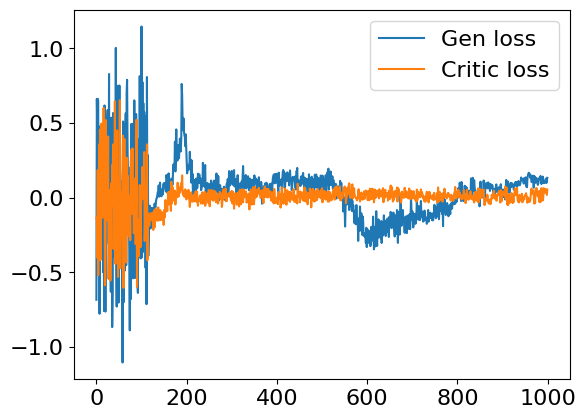

In [190]:
info_gen_losses = np.array(info_gen_losses)
info_cri_losses = np.array(info_cri_losses)
plt.plot(info_gen_losses,label="Gen loss")
plt.plot(info_cri_losses, label="Critic loss")
plt.legend()

In [191]:
from pathlib import Path

In [192]:
files = glob.glob(f'{dirpath}/GAN*')
files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
n_plot=len(files)

In [193]:
files

['./results/test2D/GAN_epoch_100.npy',
 './results/test2D/GAN_epoch_200.npy',
 './results/test2D/GAN_epoch_300.npy',
 './results/test2D/GAN_epoch_400.npy',
 './results/test2D/GAN_epoch_500.npy',
 './results/test2D/GAN_epoch_600.npy',
 './results/test2D/GAN_epoch_700.npy',
 './results/test2D/GAN_epoch_800.npy',
 './results/test2D/GAN_epoch_900.npy',
 './results/test2D/GAN_epoch_1000.npy']

In [194]:
# find the "best" plot grid 
import numbers
from math import sqrt

def get_dimensions(n):
    tempSqrt = sqrt(n)
    divisors = []
    currentDiv = 1
    for currentDiv in range(n):
        if n % float(currentDiv + 1) == 0:
         divisors.append(currentDiv+1)
    #print divisors this is to ensure that we're choosing well
    hIndex = min(range(len(divisors)), key=lambda i: abs(divisors[i]-sqrt(n)))
    
    if divisors[hIndex]*divisors[hIndex] == n:
        return divisors[hIndex], divisors[hIndex]
    else:
        wIndex = hIndex + 1
        return divisors[hIndex], divisors[wIndex]

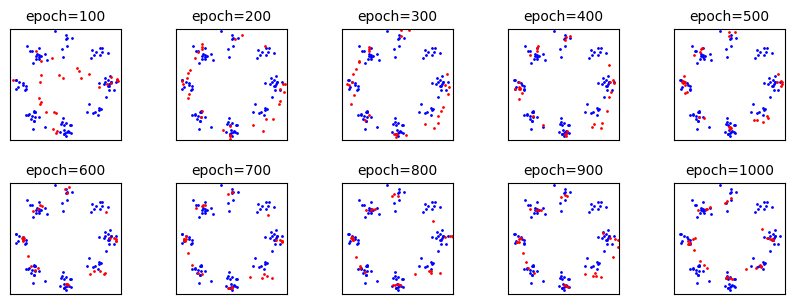

In [195]:
import re
nrows,ncols = get_dimensions(n_plot)
fig, axs = plt.subplots(nrows,ncols, figsize=(ncols*2,nrows*2))
axs = axs.ravel()
for i,f in enumerate(files):
    fname=Path(f).stem
    epoch_i = re.findall(r'\d+',fname)[0]
    spls = np.load(f)
    axs[i].scatter(X_train[:len(spls)*3,0], X_train[:len(spls)*3,1], s=1, color='blue',label='Train',alpha=1)
    axs[i].scatter(spls[:, 0], spls[:, 1], s=1, color='red',label='Gen spls',alpha=1)
    axs[i].set_title(f"epoch={epoch_i}",fontsize=10)
    
for i in range(len(axs)):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_aspect('equal')
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0)


plt.show()

In [196]:
all_spls=[]
key = jax.random.PRNGKey(12345)
for _ in range(10):
    key, key_generator  = jax.random.split(key)
    generator_input = jax.random.uniform(key_generator, (args['batch_size'], args['z_dim']), minval=-1,maxval=1)
    generator_input = shard(generator_input)
    sample = sample_from_generator(generator_state, generator_input)
    sample = sample.reshape((-1,args['x_dim']))
    all_spls.append(np.array(sample))

In [197]:
all_spls = np.array(all_spls)

In [198]:
all_spls = all_spls.reshape(-1,2)

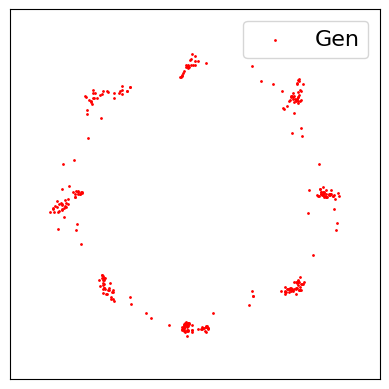

In [199]:
plt.scatter(all_spls[:, 0], all_spls[:, 1], s=1, color='red',label='Gen',alpha=1)
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect('equal')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()